In [1]:
import numpy as np
from argparse import Namespace
import matplotlib.pyplot as plt
import tensorflow as tf
# Suppress TF warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from pyemittance.emittance_calc import EmitCalc
from pyemittance.observer import Observer
from pyemittance.optics import quad_rmat_mat2, propagate_sigma
from pyemittance.data_handler import adapt_range, check_symmetry, find_inflection_pnt

# importing lcls surrogate model
%cd ../
from lcls_functions import Lcls

/Users/smiskov/Documents/SLAC/emittance_opt_playground


In [2]:
# Set random seed
seed = 9
np.random.seed(seed)
tf.random.set_seed(seed)

# Set lcls and functions
lcls_params = Namespace(
    config_bounds=[(0.46, 0.485), (-0.01, 0.01), (-0.01, 0.01)],
    quad_bounds=(-6.0, 0.0),
    beamsizes_bounds=[(0.0, 5e-4), (0.0, 5e-4)],
)
lcls = Lcls(params=lcls_params)
fn = lcls.beamsizes_list_fn
def fn_batch(x_list): return [fn(x) for x in x_list]


def get_beamsizes_model(config, val):
    beamsizes_list = fn(config, [val])[0]
    xrms = beamsizes_list[0]
    yrms = beamsizes_list[1]
    xrms_err = xrms*0.05
    yrms_err = yrms*0.05
    
    return xrms, yrms, xrms_err, yrms_err

*Initialized Lcls with params=Namespace(beamsizes_bounds=[(0.0, 0.0005), (0.0, 0.0005)], beamsizes_bounds_norm=[(-1.0, 1.0), (-1.0, 1.0)], config_bounds=[(0.46, 0.485), (-0.01, 0.01), (-0.01, 0.01)], config_bounds_norm=[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)], emit_bounds=(5e-07, 5e-06), emit_bounds_norm=(-1.0, 1.0), energy=0.135, name='Lcls', normalize=False, quad_bounds=(-6.0, 0.0), quad_bounds_norm=(0.0, 1.0), reference_point='<reference_point>', verbose=True)


In [3]:
def evaluate(varx, vary, varz):
    config = [varx, vary, varz]
    quad_init = [-5,-3,-1]
    
    # get initial points from the observer 
    o = Observer([], {'x': [] ,'y': []}, {'x': [] ,'y': []} )
    
    # set beamsize fn for MODEL
    o.get_beamsizes_model = get_beamsizes_model
    o.config = config
    
    beamsize_x_list, beamsize_y_list, xerr, yerr = o.measure_beam(quad_init)
    

    # get adapted range
    new_x_range = adapt_range(quad_init, beamsize_x_list, 'x', w=xerr)
    new_y_range = adapt_range(quad_init, beamsize_y_list, 'y', w=yerr)
    
    beamsize_x = o.measure_beam(new_x_range)
    beamsize_x_list, xerr = beamsize_x[0], beamsize_x[2] 
    beamsize_y = o.measure_beam(new_y_range)
    beamsize_y_list, yerr = beamsize_y[1], beamsize_y[3]     
       
    # check symmetry 
    add_points_x =  check_symmetry(new_x_range, beamsize_x_list, xerr, 'x', bs_fn=o.measure_beam)
    add_points_y =  check_symmetry(new_y_range, beamsize_y_list, yerr, 'y', bs_fn=o.measure_beam)
    
    if add_points_x is not None:
        new_x_range = add_points_x[0]
        beamsize_x_list = add_points_x[1]  
        xerr = add_points_x[2]  
            
    if add_points_y is not None:
        new_y_range = add_points_y[0]
        beamsize_y_list = add_points_y[1]  
        yerr = add_points_y[2]    
    

    # find infl points
    left_x, right_x =  find_inflection_pnt(new_x_range, beamsize_x_list, show_plots=True)        
    left_y, right_y =  find_inflection_pnt(new_y_range, beamsize_y_list, show_plots=True)

    # truncate data
    new_x_range = new_x_range[left_x:right_x]
    beamsize_x_list = beamsize_x_list[left_x:right_x]
    xerr = xerr[left_x:right_x]

    new_y_range = new_y_range[left_y:right_y]
    beamsize_y_list = beamsize_y_list[left_y:right_y]
    yerr = yerr[left_y:right_y]
        
        
    # finally get emittance
    # get emittance w/ new range
    ef = EmitCalc({ 'x': new_x_range, 'y': new_y_range},
                  { 'x': beamsize_x_list, 'y': beamsize_y_list},
                  { 'x': xerr, 'y': yerr}
                 )
    ef.plot=True
                  
    # get normalized transverse emittance
    emitx, errx = ef.get_emit(dim='x')
    emity, erry = ef.get_emit(dim='y')
    
    if np.isnan(emitx) or np.isnan(emity):
        return -1000

    print(emitx/1e-6, errx/1e-6, emity/1e-6, erry/1e-6)
    emit = np.sqrt(emitx*emity)/1e-6
    emit_err = emit * ( (errx/emitx)**2 + (erry/emity)**2 )**0.5 
    print(emit, emit_err)
    
    return -emit

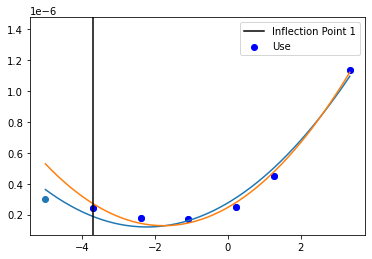

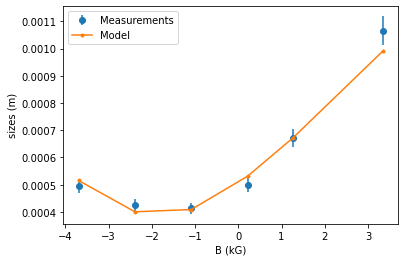

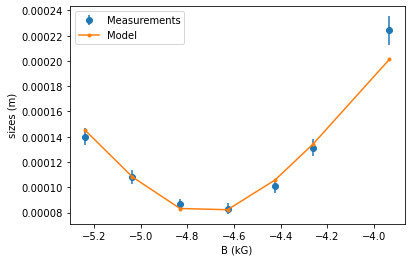

15.27023145158601 0.7209874100246819 3.9894440653282173 0.15385262119282989
7.805109495754566 0.47582568850935664
-7.805109495754566
Adjusting concave poly.


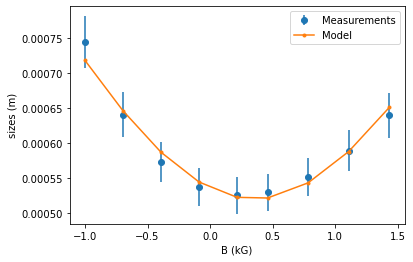

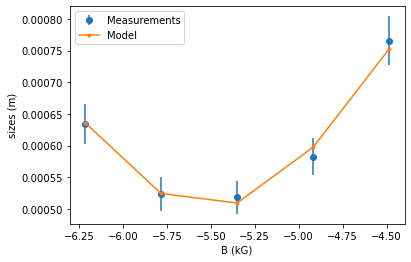

42.21312705582283 3.1692978036178028 58.76055354827689 4.423255471086646
49.80428408082876 5.2950282715973245
-49.80428408082876
Adjusting concave poly.


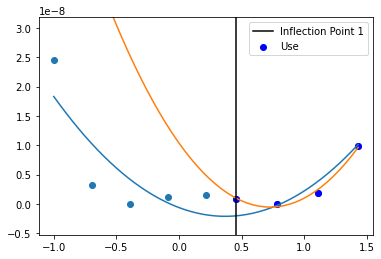

NaN


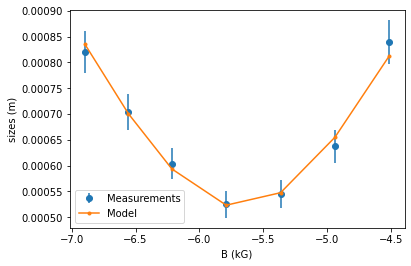

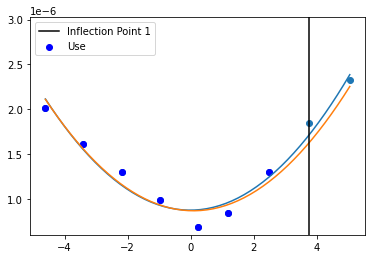

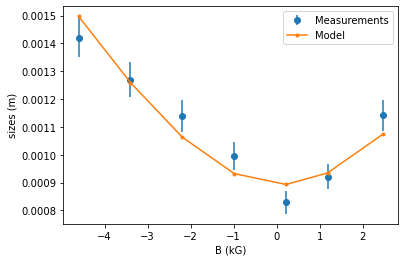

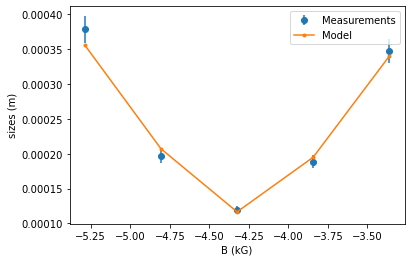

50.037367758373094 3.4720745180976005 8.50275924551251 0.4100520564659606
20.626577305229684 1.7429940218556774
-20.626577305229684


In [4]:
#evaluate( 0.5043   ,  0.000149 ,-0.01101)
#evaluate(0.4888   ,  0.002064 ,  0.001764) # errors
#evaluate(0.5136   , -0.006848 , -0.002506) # errors
#evaluate(0.51     , -0.001511 ,  0.004759)
#evaluate(0.493    ,0.01884  , -0.005015)
#evaluate(0.4932,  0.01984  , -0.005774)
print(evaluate(0.49, -0.002533, -0.002273 ))
print(evaluate(0.5438946263143039, -0.0014360730278236977, -0.012288198841713695))
evaluate( 0.549, -0.02, -0.02)

print(evaluate(  0.5026, -0.00116,  0.01996))